# Overfitting 방지 실습

## Import modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt # 학습이 어떻게 되고있는지 시각화

## 하이퍼파라미터 정의

In [2]:
EPOCHS = 50

## 네트워크 구조 정의

In [11]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten() # 28x28 = 784
        # 뉴런 수 64개 -> 많은 건 아니여서 Drop-Out 1개만 해보자
        # 전부 다 적용하면 underfitting이 일어날 수 있기때문에 마지막 layer에만 적용해보자
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(64, activation='relu')
        self.dense4 = tf.keras.layers.Dense(128, activation='relu')
        
        # Drop-Out 1개만 적용
        self.dropout4 = tf.keras.layers.Dropout(0.5)
        # 만약 Drop-Out 적용했는데 underfitting이 일어나면
        # 4번째 layer의 뉴런 수를 64개가 아닌 128개로 올려주면 복잡도를 좀 더 가지겠지
        # (지금은 강사님이 이미 128개로 올려놓았음)
        self.dense5 = tf.keras.layers.Dense(10, activation='softmax') # 10
    
    # __init__에서는 keras layer를 정의만 해주고 실제 사용하는 건 __call__에서 
    
    def call(self, x, training=False, mask=None):
        h = self.flatten(x)
        h = self.dense1(h)
        h = self.dense2(h)
        h = self.dense3(h)
        h = self.dense4(h)
        h = self.dropout4(h)
        # 4번째 dense layer 출력 중에 Drop-Out 적용해서
        # 0.5확률로 뉴런 쓸까말까 정해서 5번째 dense layer를 사용한다고 보면 됨
        return self.dense5(h)

## 데이터 불러오기

In [12]:
fashion_mnist = tf.keras.datasets.fashion_mnist # 28x28 영상, 0~9까지 9가지 class(신발, 옷, 바지, 치마 등등)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)

## 모델 생성

In [13]:
model = MyModel()

# tensorflow 2.0이 아닌 keras를 이용
# keras 이용 장점: model.compile과 model.fit으로 손쉽게 모델 학습 가능
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping Callback
- keras이용해서 학습할 땐 학습하는 과정에 관여하기가 쉽지않아
- model compile해서 어떻게 모델을 쓸 건지, 학습할 건지 해주고
- model fit을 해서 결과를 기다리는 것이기 때문에 중간에 끼어들기가 쉽지않아
- tensorflow 2.0에서 training step이나 test step을 직접 구현해서 사용할 경우에는 중간중간 원하는 결과 찍어볼 수 있고 다른 동작도 넣어줄 수가 있는데 keras는 그걸 허용하고 있지 않아
- 그래서 Callback을 사용함. 다양한 Callback 제공함
- tensorboard callback, early stopping callback 등등
- Callback : 모델 학습하는 과정에서 한번 batch가 끝날 때나 시작할 때, epoch가 시작할 때 끝날 때, training/validation이 끝날 때나 시작할 때, evaluation이 끝날 때나 시작할 때 등등 특정 동작을 할 수 있게끔 하는 것

- early stopping말고 또 다른 generalization 방법은 **Drop-Out**
- Drop-Out은 FC layer 사이에서 사용가능, 중간에 있는 뉴런들을 일부 사용하지않고 학습을 함으로써 특정 뉴런들에 너무 의존하지않게끔

In [15]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# monitor='' : 어떤 variable을 monitoring할 건지
# val_loss가 증가하는 게 바람직하지않다고 보고 있기 때문에 monitor='val_loss'
# patience : 몇 epoch까지 감소하지 않는 것을 용인할 것인가, 얼만큼 참아줄 것이냐
# verbose : 언제 EarlyStopping에 의해 멈췄는지 알기위해, verbose를 on해주면 출력을 많이 내어줄 것이냐 레벨을 통해 정할 수 있음
# verbose = 0 ;아무것도 안해 1; warning 띄어줌 2;warning과 진행상황 띄움 등등 (tip)

## 모델 학습

In [16]:
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[earlystopper])
# history 저장한 이유는 matplotlib을 이용해서 train loss와 validation loss plot해보기위해

Train for 1875 steps, validate for 313 steps
Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3777 - accuracy: 0.8642 - val_loss: 0.3840 - val_accuracy: 0.8654
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3586 - accuracy: 0.8711 - val_loss: 0.3840 - val_accuracy: 0.8573
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3343 - accuracy: 0.8802 - val_loss: 0.3832 - val_accuracy: 0.8642
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3202 - accuracy: 0.8849 - val_loss: 0.3736 - val_accuracy: 0.8683
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3118 - accuracy: 0.8860 - val_loss: 0.3760 - val_accuracy: 0.8655
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2967 - accuracy: 0.8915 - val_loss: 0.3541 - val_accuracy: 0.8754
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2924 - accura

## Matplotlib을 이용한 시각화

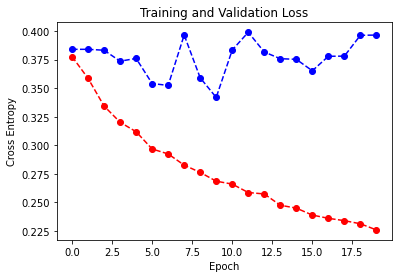

In [17]:
loss = history.history['loss'] # loss는 위의 model.fit에서 loss란 이름
val_loss = history.history['val_loss'] # 마찬가지로 위의 model.fit에서 확인가능

plt.figure() # figure창 만들어줘
plt.plot(loss, 'ro--')
plt.plot(val_loss, 'bo--')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

- training loss 점점 감소
- validation loss는 흔들리면서 감소하는 듯 싶더니 증가하는 추세
- 어느정도 underfitting, optimize, overfitting zone이 있다는 걸 명확히 확인 가능하지
- model을 수정해서 위 상황을 개선해보자
- 1. early stopping 사용해보자
- 2. Drop out
<br>
<br>
- *<early stopping 사용 후 결과>*
- validation이 처음부터 학습이 안됐다고 나옴
- val_loss 약 0.5 정도
<br>
<br>
- *<Drop-Out 사용 후 결과>*
- val_loss가 약 0.4수준에서 끝났음
- Drop-Out 적용하기 전이랑 비슷한 수준임 (Drop-Out이 힘을 잘 못 썼다고 볼 수 있음)
- 힘을 잘 쓸 수 있게 self.dense4의 뉴런 수를 128로 올려서 해보자
- 아까 0.4보다는 더 나은 수준으로 학습이 되었음
- 하지만 dramatic하게 좋아지진 않았음
- 이렇게 generalization 문제를 푸는 건 굉장히 어려운 일
- 여러가지 기법들도 있음, Regualization이나 Batch normalization 사용한다는 등